# A Date with Deep Learning

Learn how to build a small model that can classify topwear vs bottomwear from the Myntra catalog.

---

# Create Dataset

Fetch a random set of styleids, and download the corresponding product images.
A dataset of just 2000 images is good enough for this usecase.

In [ ]:
import json
import requests
import urllib.request

# read data file
with open('data.json') as data_file:
    data = json.load(data_file)

# iterate over a range of style ids
for styleid in range(1322000, 1323000):
    try:
        print('Downloading ' + str(styleid) + '...')
        
        # hit style service
        r = requests.get(url='http://developer.myntra.com/style/' + str(styleid)).json()
        
        # generarate url for product image
        imageURL = r['data']['styleImages']['default']['imageURL'].replace('assets.myntassets.com/', 'assets.myntassets.com/w_60/')

        # download the image and save
        urllib.request.urlretrieve(imageURL, 'data/' + str(styleid) + '.jpg')

        # update data object with meta
        data[styleid] = {
            "masterCategory": r['data']['masterCategory']['typeName'],
            "subCategory": r['data']['subCategory']['typeName'],
            "articleType": r['data']['articleType']['typeName']
        }

    except:
        # ignore images that result in an error
        pass

# save back the meta data
with open('data.json', 'w') as outfile:
    json.dump(data, outfile)

# Investigate dataset

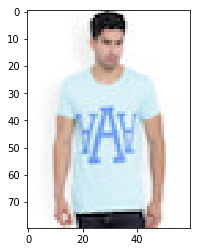

(80, 60, 3)


In [27]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

image = mpimg.imread('data/' + '1320032' + '.jpg')
plt.imshow(image)
plt.show()
print(image.shape)

# Train Model

In [67]:
import json
import matplotlib
import pickle
import numpy as np
import matplotlib.image as mpimg

from numpy import newaxis
from keras.models import Sequential, load_model
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dropout, Dense
    
def read_data(batch_size):
    """
    Generator function to load driving logs and input images.
    """
    while 1:
        with open('data.json') as data_file:
            data = json.load(data_file)
            count = 0
            inputs = []
            targets = []
            try:
                for styleid, category in data.items():

                    # ignore all other types and add class label to each image
                    label = 0
                    if category['subCategory'] == 'Topwear':
                        label = 0
                    elif category['subCategory'] == 'Bottomwear':
                        label = 1
                    else:
                        continue
                        
                    # read image and create a flipped version
                    image = mpimg.imread('data/' + styleid + '.jpg')
                    flip_image = np.fliplr(image)
                    
                    # ignore greyscale images in dataset
                    if len(image.shape) == 2:
                        continue
                    
                    # loop
                    if count == 0:
                        inputs = np.empty([0, 80, 60, 3], dtype=int)
                        targets = np.empty([0, ], dtype=int)
                    
                    # add images to array till we create batch
                    if count < int(batch_size/2):
                        inputs = np.append(inputs, np.array([image, flip_image]), axis=0)
                        targets = np.append(targets, np.array([label, label]), axis=0)
                        count += 1
                        
                    # yield the batch of images when done
                    else:
                        yield inputs, targets
                        count = 0
            except StopIteration:
                pass

sample_count = 1000
batch_size = 10
use_transfer_learning = False

# define model
if use_transfer_learning:
    model = load_model('model.h5')
else:
    model = Sequential()
    model.add(Convolution2D(2, 5, 5, border_mode='valid', activation='relu', input_shape=(80, 60, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Convolution2D(4, 5, 5, border_mode='valid', activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Convolution2D(8, 5, 5, border_mode='valid', activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# train model
model.fit_generator(read_data(batch_size), samples_per_epoch=sample_count, nb_epoch=5, verbose=2)
model.save('model.h5')


Epoch 1/5
4s - loss: 0.4623 - acc: 0.8580
Epoch 2/5
3s - loss: 0.1746 - acc: 0.9440
Epoch 3/5
3s - loss: 0.1268 - acc: 0.9570
Epoch 4/5
3s - loss: 0.0729 - acc: 0.9790
Epoch 5/5
4s - loss: 0.0567 - acc: 0.9810


# Test Model

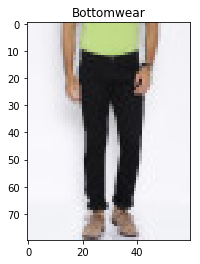

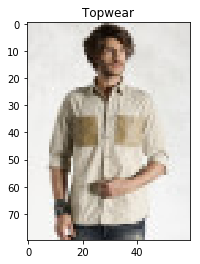

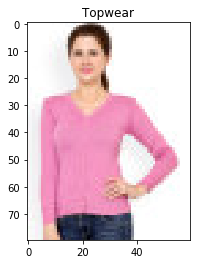

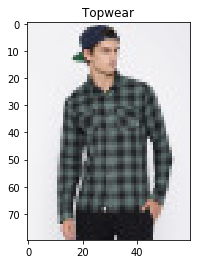

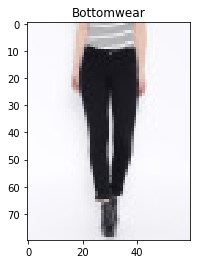

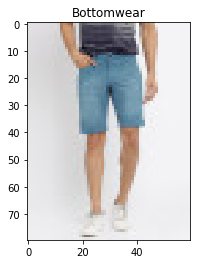

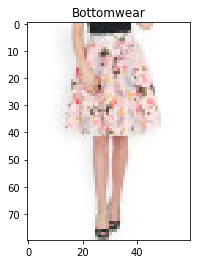

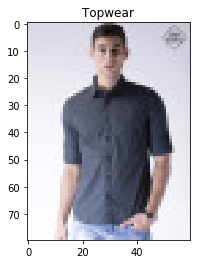

In [70]:
import requests
import urllib.request
import matplotlib.pyplot as plt

styleids = [1456039, 1116823, 1024476, 1595888, 1062662, 1392558, 1377086, 1468462]

for styleid in styleids:
    # download image and read
    r = requests.get(url='http://developer.myntra.com/style/' + str(styleid)).json()
    imageURL = r['data']['styleImages']['default']['imageURL'].replace('assets.myntassets.com/', 'assets.myntassets.com/w_60/')
    urllib.request.urlretrieve(imageURL, 'data/' + str(styleid) + '.jpg')
    image = mpimg.imread('data/' + str(styleid) + '.jpg')
    
    # predict what type is it
    prediction = model.predict_classes(np.array([image]), verbose=0)[0]

    # visualize prediction
    plt.title('Topwear' if prediction==0 else 'Bottomwear')
    plt.imshow(image)
    plt.show()